In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

import sys
import pprint
import argparse
import datetime
import random
import copy

from model import Basic
from ql_mpcm import QL_MPCM
from mpcm import MPCM
from utils import *
from dataset import read_data, build_dict, load_glove, preprocess

from time import gmtime, strftime
from matplotlib.table import Table

[nltk_data] Downloading package punkt to /home/jinhyuk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
flags = {}
flags['train_epoch'] = 100
flags['test_epoch'] = 1
flags['batch_size'] = 32
flags['dim_perspective'] = 20
flags['dim_embed_word'] = 300
flags['dim_rnn_cell'] = 100
flags['dim_hidden'] = 100
flags['num_paraphrase'] = 1
flags['rnn_layer'] = 1
flags['context_maxlen'] = 200
flags['validation_cnt'] = 100
flags['rnn_dropout'] = 0.5
flags['hidden_dropout'] = 0.5
flags['embed_dropout'] = 0.8
flags['learning_rate'] = 0.00162
flags['max_grad_norm'] = 5.0
flags['embed_trainable'] = False
flags['test'] = False
flags['debug'] = False
flags['save'] = False
flags['sample_params'] = False
flags['mode'] = 'm'
flags['model_name'] = 'm'
flags['train_path'] = './data/train-v1.1.json'
flags['dev_path'] = './data/dev-v1.1.json'
flags['pred_path'] = './result/dev-v1.1-pred.json'
flags['glove_path'] = '~/common/glove/glove.840B.'+ str(flags['dim_embed_word']) +'d.txt'
flags['checkpoint_dir'] = './result/ckpt'

# Basic model settings
flags["batch_size"] = 32
flags["dim_embed_word"] = 300
flags["dim_rnn_cell"] = 100
flags["dim_hidden"] = 100
flags["rnn_layer"] = 1
flags["context_maxlen"] = 100
flags["rnn_dropout"] = 0.5
flags["hidden_dropout"] = 0.5
flags["embed_dropout"] = 0.8
flags["learning_rate"] = 0.00162
flags["max_grad_norm"] = 5.0

# Run options
flags['train_epoch'] = 100
flags['test_epoch'] = 1
flags["validation_cnt"] = 100
flags["debug"] = False
flags["save"] = False
flags["sample_params"] = False
flags["early_stop"] = False
flags["load"] = False
flags["train"] = True
flags["embed_trainable"] = False
flags["load_name"] = "m100_300d6B"
flags["model_name"] = "none"
flags["mode"] = "m"

# MPCM settings
flags["dim_perspective"] = 20

# Paraphrase settings
flags["num_paraphrase"] = 1
flags["num_action"] = 2
flags["train_pp_only"] = True

# Bidaf settings
flags["input_keep_prob"] = 0.8
flags["wd"] = 0.0
flags["share_lstm_weights"] = True
flags['logit_func'] = 'tri_linear'
flags['answer_func'] = 'linear'

# Path settings
flags['train_path'] = './data/train-v1.1.json'
flags['dev_path'] = './data/dev-v1.1.json'
flags['pred_path'] = './result/dev-v1.1-pred.json'
flags["glove_size"] = "6"
flags['glove_path'] = '~/common/glove/glove.' + str(flags['glove_size']) + 'B.' + str(flags['dim_embed_word']) +'d.txt'
flags['checkpoint_dir'] = './result/ckpt'

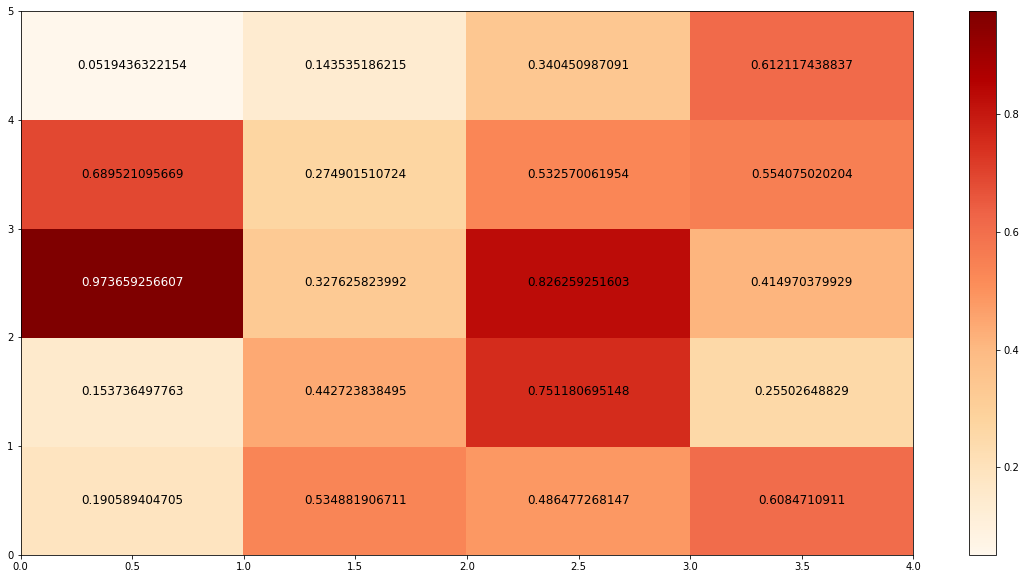

In [3]:
def checkerboard_table(data, text=None):
    data = np.array([i for i in reversed(data)])
    max_idx = np.argmax(data.flatten())
    # print(max_idx)
    heatmap = plt.pcolor(data, cmap='OrRd')
    if text is None:
        text = data
    else:
        text = np.array([i for i in reversed(text)])
    # print(data)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if x + y * data.shape[1] == max_idx:
                color = 'white'
            else:
                color = 'black'
            plt.text(x + 0.5, y + 0.5, '%s' % text[y, x],
                     horizontalalignment='center',
                     verticalalignment='center', color=color, fontsize=12)

    plt.colorbar(heatmap)

plt.figure(figsize=(20,10))
data = np.random.rand(5, 4)
checkerboard_table(data)
plt.show()

In [4]:
# Load dataset once
expected_version = '1.1'
train_path = flags['train_path']
dev_path = flags['dev_path']
train_dataset = read_data(train_path, expected_version)
dev_dataset = read_data(dev_path, expected_version)

# Preprocess dataset
saved_params = flags
word2idx, idx2word, c_maxlen, q_maxlen = build_dict(train_dataset, saved_params)
pretrained_glove, word2idx, idx2word = load_glove(word2idx, saved_params)
if saved_params['context_maxlen'] > 0: 
    c_maxlen = saved_params['context_maxlen']

train_dataset = preprocess(train_dataset, word2idx, c_maxlen, q_maxlen)
dev_dataset = preprocess(dev_dataset, word2idx, c_maxlen, q_maxlen)
saved_params['context_maxlen'] = c_maxlen
saved_params['question_maxlen'] = q_maxlen
saved_params['voca_size'] = len(word2idx)
saved_params['dim_output'] = c_maxlen

Top 20 frequent words among 115725
[('the', 226249), (',', 153792), ('of', 130373), ('.', 94599), ('?', 86971), ('and', 85949), ('in', 77720), ('to', 70230), ('a', 52322), ('What', 37642), ('is', 37116), ('was', 36202), ('"', 29199), ('The', 26296), ('as', 24940), ('for', 23770), ("'s", 23283), ('(', 21446), (')', 21437), ('that', 20756)]
Falangists 2
digit cnt 1894
non alpha cnt 23593
Dictionary size 115725
[('!', 0), ('"', 1), ('"Beautiful', 2), ('"Carmen', 3), ('"Deja', 4), ('"Nigeria', 5), ('"The', 6), ('"narrow', 7), ('#', 8), ('$', 9), ('%', 10), ('&', 11), ("'", 12), ("'00", 13), ("'00s", 14), ("'01", 15), ("'02", 16), ("'03", 17), ("'04", 18), ("'040", 19)]
Maxlen of C:766, Q:60, A:46
Glove Loading...
Glove Loading Done 0:00:43.055943 400000
apple: 6909 [-0.20842, -0.019668, 0.063981, -0.71403, -0.21181]
Pretrained vectors (46618, 300) unk 69109
Dictionary Change 115725 to 46618 46618
Passage: 4974, Question: 20613
Passage: 455, Question: 2289


In [7]:
params = copy.deepcopy(flags)
pprint.PrettyPrinter().pprint(params)

# my_model.reset_graph()
# set model name
params['model_name'] = 'm100_300d6B'

# Make model and run experiment
if 'm' in params['mode'] :
    my_model = MPCM(params, initializer=[pretrained_glove, word2idx])
elif 'q' in params['mode']:
    my_model = QL_MPCM(params, initializer=[pretrained_glove, word2idx])
elif 'b' in params['mode']:
    my_model = Basic(params, initializer=[pretrained_glove, word2idx])
else:
    assert False, "Check your version %s" % params['model']

my_model.load(params['checkpoint_dir'])

{'answer_func': 'linear',
 'batch_size': 32,
 'checkpoint_dir': './result/ckpt',
 'context_maxlen': 100,
 'debug': False,
 'dev_path': './data/dev-v1.1.json',
 'dim_embed_word': 300,
 'dim_hidden': 100,
 'dim_output': 100,
 'dim_perspective': 20,
 'dim_rnn_cell': 100,
 'early_stop': False,
 'embed_dropout': 0.8,
 'embed_trainable': False,
 'glove_path': '~/common/glove/glove.6B.300d.txt',
 'glove_size': '6',
 'hidden_dropout': 0.5,
 'input_keep_prob': 0.8,
 'learning_rate': 0.00162,
 'load': False,
 'load_name': 'm100_300d6B',
 'logit_func': 'tri_linear',
 'max_grad_norm': 5.0,
 'mode': 'm',
 'model_name': 'none',
 'num_action': 2,
 'num_paraphrase': 1,
 'pred_path': './result/dev-v1.1-pred.json',
 'question_maxlen': 60,
 'rnn_dropout': 0.5,
 'rnn_layer': 1,
 'sample_params': False,
 'save': False,
 'share_lstm_weights': True,
 'test': False,
 'test_epoch': 1,
 'train': True,
 'train_epoch': 100,
 'train_path': './data/train-v1.1.json',
 'train_pp_only': True,
 'validation_cnt': 100,
 

[context] len=89
The adoption of compounding was common for industrial units , for road engines and almost universal for marine engines after 1880 ; it was not universally popular in railway locomotives where it was often perceived as complicated . This is partly due to the harsh railway operating environment and limited space afforded by the loading gauge ( particularly in Britain , where compounding was never common and not employed after 1930 ) . However , although never in the majority , it was popular in many other countries .

[question] len=11
Compounding was not popular in the construction of what machines ?

[ground truth]
['railway locomotives', 'railway locomotives', 'railway locomotives']

[prediction]
compounding



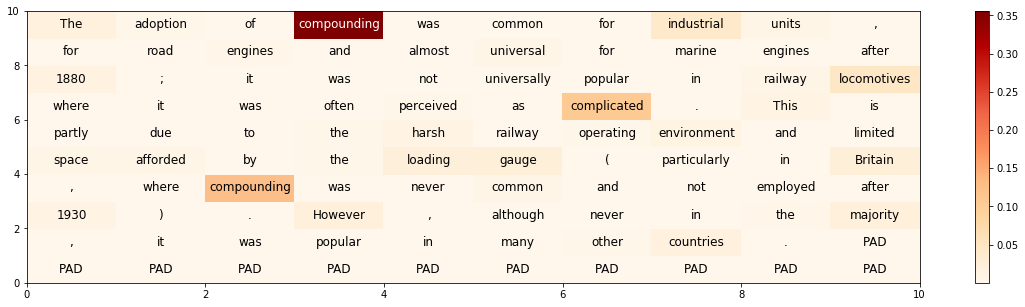

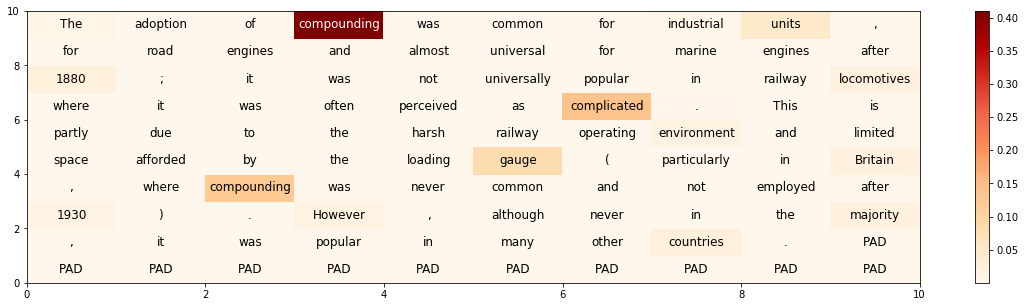

[loss: 8.743, f1: 0.000, em: 0.000]



In [12]:
model = my_model
sess = model.session
batch_size = params['batch_size']
mini_batch = []
ground_truths = []
context_raws = []
question_raws = []

total_loss = total_f1 = total_em = total_cnt = 0
dataset = dev_dataset

for context_idx, dataset_item in enumerate(dataset[243:244]):
    context = dataset_item['c']
    context_raw = dataset_item['c_raw']
    context_real = dataset_item['c_real']
    context_len = dataset_item['c_len']
    for q_idx, qa in enumerate(dataset_item['qa'][1:2]):
        question = qa['q']
        question_len = qa['q_len']
        question_raw = qa['q_raw']
        answer = qa['a']
        answer_start = qa['a_start']
        answer_end = qa['a_end']

        ground_truths = [answer]
        context_raws = [context_raw]
        question_raws = [question_raw]

        batch_context = [context]
        batch_context_len = [context_len]
        batch_question = [question]
        batch_question_len = [question_len]
        batch_answer_start = [answer_start]
        batch_answer_end = [answer_end]
        
        if 0:
            paraphrase = 'A multi-tape Turing machine can be solved in what type of time ?'
            question_raws = [paraphrase.split(' ')]
            batch_question_len = [len(paraphrase.split(' '))]
            batch_question = [[word2idx[w] if w in word2idx else word2idx['UNK'] for w in paraphrase.split(' ')]]
            while len(batch_question[0]) != model.question_maxlen:
                batch_question[0] = np.append(batch_question[0], word2idx['PAD'])
            
        feed_dict = {model.context: batch_context,
            model.context_len: batch_context_len,
            model.question: batch_question,
            model.question_len: batch_question_len,
            model.answer_start: batch_answer_start,
            model.answer_end: batch_answer_end,
            model.rnn_dropout: 1.0,
            model.hidden_dropout: 1.0,
            model.embed_dropout: 1.0}

        loss, start_logits, end_logits = sess.run(
                [model.loss, model.start_logits, model.end_logits], 
                feed_dict=feed_dict)
        start_idx = [np.argmax(sl[:cl], 0)
                for sl, cl in zip(start_logits, batch_context_len)]
        end_idx = [np.argmax(el[si:cl], 0) + si
                for el, si, cl in zip(end_logits, start_idx, batch_context_len)]
        predictions = []
        
        for c, s_idx, e_idx in zip(context_raws, start_idx, end_idx):
            predictions.append(' '.join([w for w in c[s_idx: e_idx+1]]))
        
        em = f1 = 0
        assert len(predictions) == 1
        for prediction, ground_truth, ctr, qur in zip(
                predictions, ground_truths, context_raws, question_raws):
            
            single_em = metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truth)
            single_f1 = metric_max_over_ground_truths(
                    f1_score, prediction, ground_truth)
            
            test_correct = True if single_f1 > 0 else False
            """
            if not test_correct and np.amax(softmax(start_logits[0])) > 0.8:
                print('### Worst mistakes ### prob:%.3f, idx:%d at context %d, question %d' % (
                    np.amax(softmax(start_logits[0])), np.argmax(start_logits[0]), context_idx, q_idx))
            # continue
            """
                                        
            test_c = str(' '.join(ctr))
            print('[context] len=%d\n%s\n' % (len(ctr), test_c))
            # print('[context] len=%d\n%s\n' % (context_len, context_real))
            test_q = str(' '.join(qur))
            print('[question] len=%d\n%s\n' % (len(qur), test_q))
            test_gt = str(ground_truth)
            print('[ground truth]\n%s\n' % test_gt)
            test_pr = str(prediction)
            print('[prediction]\n%s\n' % test_pr)
            
            while len(ctr) != len(start_logits[0]):
                ctr = np.append(ctr, 'PAD')
            
            def softmax(x):
                e_x = np.exp(x - np.max(x))
                return e_x / e_x.sum(axis=0)
            
            plot_size = 10
            plt.figure(figsize=(20,5))
            data = np.reshape(softmax(start_logits[0]), (plot_size, 10))
            text = np.reshape(ctr, (plot_size, 10))
            checkerboard_table(data, text)
            plt.show()
            
            plt.figure(figsize=(20,5))
            data = np.reshape(softmax(end_logits[0]), (plot_size, 10))
            checkerboard_table(data, text)
            plt.show()

            em += single_em
            f1 += single_f1

        _progress = "[loss: %.3f, f1: %.3f, em: %.3f]\n\n" % (loss, f1 /
                len(predictions), em / len(predictions)) 
        sys.stdout.write(_progress)
        sys.stdout.flush()
        
        # break

In [ ]:
### Worst mistakes ### prob:0.963, idx:94 at context 0, question 4
### Worst mistakes ### prob:0.898, idx:22 at context 0, question 20
### Worst mistakes ### prob:0.890, idx:14 at context 0, question 29
### Worst mistakes ### prob:0.864, idx:109 at context 1, question 17
### Worst mistakes ### prob:0.804, idx:11 at context 6, question 17
### Worst mistakes ### prob:0.925, idx:51 at context 7, question 17
### Worst mistakes ### prob:0.888, idx:51 at context 7, question 22
### Worst mistakes ### prob:0.907, idx:46 at context 11, question 9
### Worst mistakes ### prob:0.867, idx:4 at context 13, question 12
### Worst mistakes ### prob:0.801, idx:4 at context 13, question 14
### Worst mistakes ### prob:0.889, idx:40 at context 15, question 8
### Worst mistakes ### prob:0.802, idx:40 at context 15, question 11
### Worst mistakes ### prob:0.901, idx:37 at context 16, question 4
### Worst mistakes ### prob:0.953, idx:37 at context 16, question 5
### Worst mistakes ### prob:0.886, idx:8 at context 17, question 2
### Worst mistakes ### prob:0.886, idx:8 at context 17, question 5
### Worst mistakes ### prob:0.837, idx:42 at context 20, question 8
### Worst mistakes ### prob:0.925, idx:45 at context 20, question 11
### Worst mistakes ### prob:0.944, idx:16 at context 23, question 2
### Worst mistakes ### prob:0.972, idx:26 at context 24, question 17
### Worst mistakes ### prob:0.881, idx:29 at context 27, question 1
### Worst mistakes ### prob:0.825, idx:20 at context 31, question 0
### Worst mistakes ### prob:0.917, idx:4 at context 33, question 1
### Worst mistakes ### prob:0.870, idx:18 at context 33, question 8
### Worst mistakes ### prob:0.804, idx:30 at context 36, question 2
### Worst mistakes ### prob:0.850, idx:39 at context 36, question 4
### Worst mistakes ### prob:0.895, idx:39 at context 36, question 8
### Worst mistakes ### prob:0.981, idx:0 at context 39, question 0
### Worst mistakes ### prob:0.921, idx:7 at context 39, question 8
### Worst mistakes ### prob:0.984, idx:0 at context 39, question 10
### Worst mistakes ### prob:0.812, idx:7 at context 39, question 11
### Worst mistakes ### prob:0.862, idx:83 at context 40, question 5
### Worst mistakes ### prob:0.813, idx:83 at context 40, question 8
### Worst mistakes ### prob:0.832, idx:80 at context 41, question 7
### Worst mistakes ### prob:0.833, idx:69 at context 42, question 8
### Worst mistakes ### prob:0.987, idx:71 at context 46, question 0
### Worst mistakes ### prob:0.957, idx:71 at context 46, question 2
### Worst mistakes ### prob:0.970, idx:86 at context 46, question 10
### Worst mistakes ### prob:0.832, idx:34 at context 47, question 3
### Worst mistakes ### prob:0.851, idx:134 at context 47, question 4
### Worst mistakes ### prob:0.863, idx:34 at context 47, question 12
### Worst mistakes ### prob:0.823, idx:36 at context 48, question 3
### Worst mistakes ### prob:0.835, idx:102 at context 54, question 4
### Worst mistakes ### prob:0.928, idx:31 at context 67, question 0
### Worst mistakes ### prob:0.846, idx:33 at context 69, question 2
### Worst mistakes ### prob:0.960, idx:85 at context 77, question 3
### Worst mistakes ### prob:0.982, idx:39 at context 82, question 1
### Worst mistakes ### prob:0.869, idx:45 at context 103, question 0
### Worst mistakes ### prob:0.951, idx:37 at context 106, question 1
### Worst mistakes ### prob:0.880, idx:19 at context 121, question 0
### Worst mistakes ### prob:0.916, idx:14 at context 122, question 0
### Worst mistakes ### prob:0.846, idx:22 at context 122, question 2
### Worst mistakes ### prob:0.803, idx:0 at context 132, question 5
### Worst mistakes ### prob:0.899, idx:112 at context 136, question 8
### Worst mistakes ### prob:0.895, idx:81 at context 138, question 9
### Worst mistakes ### prob:0.924, idx:105 at context 146, question 5
### Worst mistakes ### prob:0.807, idx:32 at context 147, question 5
### Worst mistakes ### prob:0.912, idx:92 at context 148, question 3
### Worst mistakes ### prob:0.871, idx:188 at context 158, question 1
### Worst mistakes ### prob:0.835, idx:188 at context 158, question 6
### Worst mistakes ### prob:0.857, idx:17 at context 159, question 7
### Worst mistakes ### prob:0.889, idx:74 at context 166, question 3
### Worst mistakes ### prob:0.949, idx:153 at context 180, question 2
### Worst mistakes ### prob:0.849, idx:117 at context 193, question 2
### Worst mistakes ### prob:0.814, idx:0 at context 200, question 3
### Worst mistakes ### prob:0.961, idx:133 at context 204, question 3
### Worst mistakes ### prob:0.983, idx:50 at context 206, question 0
### Worst mistakes ### prob:0.926, idx:50 at context 206, question 1
### Worst mistakes ### prob:0.983, idx:20 at context 208, question 0
### Worst mistakes ### prob:0.893, idx:34 at context 211, question 0
### Worst mistakes ### prob:0.879, idx:38 at context 218, question 4
### Worst mistakes ### prob:0.819, idx:55 at context 223, question 1
### Worst mistakes ### prob:0.885, idx:47 at context 226, question 1
### Worst mistakes ### prob:0.879, idx:51 at context 237, question 2
### Worst mistakes ### prob:0.928, idx:55 at context 243, question 1
### Worst mistakes ### prob:0.896, idx:8 at context 257, question 1
### Worst mistakes ### prob:0.951, idx:33 at context 262, question 3
### Worst mistakes ### prob:0.881, idx:14 at context 270, question 3
### Worst mistakes ### prob:0.836, idx:7 at context 281, question 4
### Worst mistakes ### prob:0.860, idx:0 at context 289, question 1
### Worst mistakes ### prob:0.895, idx:0 at context 289, question 2
### Worst mistakes ### prob:0.922, idx:92 at context 291, question 4
### Worst mistakes ### prob:0.903, idx:13 at context 293, question 1
### Worst mistakes ### prob:0.860, idx:15 at context 306, question 2
### Worst mistakes ### prob:0.916, idx:23 at context 311, question 3
### Worst mistakes ### prob:0.832, idx:0 at context 314, question 1
### Worst mistakes ### prob:0.805, idx:53 at context 315, question 4
### Worst mistakes ### prob:0.866, idx:45 at context 327, question 2
### Worst mistakes ### prob:0.810, idx:57 at context 333, question 3
### Worst mistakes ### prob:0.891, idx:48 at context 349, question 2
### Worst mistakes ### prob:0.934, idx:23 at context 351, question 0
### Worst mistakes ### prob:0.911, idx:7 at context 356, question 2
### Worst mistakes ### prob:0.823, idx:106 at context 363, question 1
### Worst mistakes ### prob:0.888, idx:55 at context 372, question 4
### Worst mistakes ### prob:0.901, idx:6 at context 385, question 1
### Worst mistakes ### prob:0.802, idx:62 at context 386, question 1


### Worst mistakes ### prob:0.988, idx:71 at dataset 46   => Ealy parpahrase problem
### Worst mistakes ### prob:0.912, idx:31 at dataset 67   => Jazdów substitue problem
### Worst mistakes ### prob:0.925, idx:17 at dataset 194
### Worst mistakes ### prob:0.875, idx:34 at dataset 211
### Worst mistakes ### prob:0.870, idx:35 at dataset 228
### Worst mistakes ### prob:0.921, idx:8 at dataset 244
### Worst mistakes ### prob:0.850, idx:99 at dataset 316
### Worst mistakes ### prob:0.971, idx:0 at dataset 321
### Worst mistakes ### prob:0.851, idx:28 at dataset 325
### Worst mistakes ### prob:0.888, idx:55 at dataset 372
### Worst mistakes ### prob:0.858, idx:28 at dataset 380